In [1]:
import matplotlib.pyplot as plt
# import os, sys
import numpy as np
from glob import glob
import pandas as pd
import warnings
from datetime import datetime, timedelta

In [2]:
warnings.filterwarnings("ignore")

In [3]:
logfiles = glob('../test_data/strategy_testing_logs/*/*.log')

In [4]:
logfiles

['../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_5perc_small_4.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_5perc_small_8.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_50perc_small_16.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_100perc_small_8.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_100perc_small_48.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_10perc_small_32.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy-test_dummy-data_no-collation_5perc_small_32.log',
 '../test_data/strategy_testing_logs/dummy-data_no-collation/no-collate_strategy

In [5]:
logs = []
for logfile in logfiles:
    title_name = logfile.split("/")[-1].split(".")[0]
    title_cards = title_name.split("_")
    # Define the regular expression pattern to match the desired lines

    # Lists to store the extracted data
    mbps = np.nan
    sec_per_file = np.nan
    time_for_upload = np.nan
    total_MiB_uploaded = np.nan
    total_files_uploaded = np.nan
    collated = True
    compressed = True
    upload_sizes = []
    upload_times = []
    upload_speeds = []

    with open(logfile, 'r') as lf:
        for line in lf.readlines():
            #Possible lines:
            #Finished at 2024-05-29 20:38:23.761037, elapsed time = 0:00:49.929613
            #Total: 9 files; 4608.00 MiB; 92.29 MiB/s including setup time; 5.55 s/file including setup time
            if 'Finished at' in line:
                total_runtime = datetime.strptime(line.split()[-1], '%H:%M:%S.%f') - datetime(1900, 1, 1, 0, 0, 0, 0)
            elif 'Total:' in line:
                mbps = float(line.split()[5])*8
                sec_per_file = float(line.split()[10])
                total_MiB_uploaded = float(line.split()[3])
                total_files_uploaded = int(line.split()[1])
            elif 'MiB uploaded in' in line:
                upload_sizes.append(float(line.split()[0]))
                upload_times.append(timedelta(seconds = float(line.split()[4])))
                # upload_speeds.append(float(line.split()[6])) # bug in logs - calculated below
    if title_cards[0] == "no-collate":
        collated = False
        compressed = False
    if title_cards[0] == "no-compression":
        compressed = False
    n_procs = int(''.join(filter(str.isdigit,title_cards[-1].split(".")[0])))
    average_upload_time = np.mean(upload_times)

    #something wrong here - average speed appears to be double of total speed
    average_upload_speed = np.mean(np.array(upload_sizes) / (float(average_upload_time.seconds) + float(average_upload_time.microseconds)/1e6))
    mbps = total_MiB_uploaded / (float(total_runtime.seconds) + float(total_runtime.microseconds)/1e6)
    # overheads_time = total_runtime - average_upload_time*total_files_uploaded

    if 'merged' in title_cards:
        if 'vhs' in title_cards:
            ds = 'VHS-merged'
        elif 'video' in title_cards:
            ds = 'VIDEO-merged'
        else:
            ds = 'Unknown'
    elif 'vhs' in title_cards:
            ds = 'CSV-VHS'
    elif 'dummy-data' in title_cards:
        if '1perc' in title_cards:
            ds = 'Dummy Data 1% Small Files'
        elif '10perc' in title_cards:
            ds = 'Dummy Data 10% Small Files'
        elif '100perc' in title_cards:
            ds = 'Dummy Data 100% Small Files'
        elif '25perc' in title_cards:
            ds = 'Dummy Data 25% Small Files'
        elif '50perc' in title_cards:
            ds = 'Dummy Data 50% Small Files'
        else:
            ds = 'Unknown'

    else:
        ds = 'Unknown'

    logs.append({'Title':title_name,
                 'Dataset':ds,
                 'Transfer Speed / MiB/s':mbps,
                 'Seconds per File':sec_per_file,
                 'CPU Count':n_procs,
                 'Average Time per Upload / s':average_upload_time,
                 'Average Speed per Upload / MiB/s':average_upload_speed,
                 'Total Time':total_runtime,
                 'Total MiB Uploaded':total_MiB_uploaded,
                 'Total Files Uploaded':total_files_uploaded,
                #  'Estimated Overheads Time':overheads_time,
                 'Collated':collated,
                 'Compressed':compressed}
                 )

In [6]:
logs

[{'Title': 'no-collate_strategy-test_dummy-data_no-collation_5perc_small_4',
  'Dataset': 'Unknown',
  'Transfer Speed / MiB/s': 165.97803514776407,
  'Seconds per File': 0.59,
  'CPU Count': 4,
  'Average Time per Upload / s': datetime.timedelta(seconds=2, microseconds=323100),
  'Average Speed per Upload / MiB/s': 83.93956351426972,
  'Total Time': datetime.timedelta(seconds=117, microseconds=485425),
  'Total MiB Uploaded': 19500.0,
  'Total Files Uploaded': 200,
  'Collated': False,
  'Compressed': False},
 {'Title': 'no-collate_strategy-test_dummy-data_no-collation_5perc_small_8',
  'Dataset': 'Unknown',
  'Transfer Speed / MiB/s': 327.52474084101,
  'Seconds per File': 0.3,
  'CPU Count': 8,
  'Average Time per Upload / s': datetime.timedelta(seconds=2, microseconds=229700),
  'Average Speed per Upload / MiB/s': 87.45571153069919,
  'Total Time': datetime.timedelta(seconds=59, microseconds=537487),
  'Total MiB Uploaded': 19500.0,
  'Total Files Uploaded': 200,
  'Collated': Fals

In [7]:
logs_df = pd.DataFrame(logs).sort_values(by=['Dataset','CPU Count','Collated','Compressed']).reset_index(drop=True)
# logs_df.drop(logs_df[logs_df['files_per_folder'] == 2].index, inplace=True)
logs_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
0,no-collate_butler_wide_csv_vhs_4,CSV-VHS,132.625259,0.32,4,0 days 00:00:01.270537,66.500249,0 days 00:15:43.495082,125131.28,2962,False,False
1,no-compression_butler_wide_csv_vhs_4,CSV-VHS,135.741531,0.75,4,0 days 00:00:02.241205,68.683595,0 days 00:15:16.172735,124362.69,1220,True,False
2,collate_butler_wide_csv_vhs_4,CSV-VHS,56.135799,1.23,4,0 days 00:00:01.592230,75.934433,0 days 00:24:57.575734,84067.61,1220,True,True
3,no-collate_butler_wide_csv_vhs_8,CSV-VHS,262.200988,0.16,8,0 days 00:00:01.282397,65.885234,0 days 00:07:57.234204,125131.28,2962,False,False
4,no-compression_butler_wide_csv_vhs_8,CSV-VHS,234.282983,0.48,8,0 days 00:00:02.222973,75.631883,0 days 00:08:52.971872,124866.24,1120,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
130,no-compression_butler_wide_csv_video_merged_32,VIDEO-merged,145.239852,3.23,32,0 days 00:00:04.231667,110.888530,0 days 00:00:19.384900,2815.46,6,True,False
131,collate_butler_wide_csv_video_merged_32,VIDEO-merged,17.277014,11.03,32,0 days 00:00:02.366667,80.507735,0 days 00:01:06.168843,1143.20,6,True,True
132,no-collate_butler_wide_csv_video_merged_48,VIDEO-merged,274.319975,0.05,48,0 days 00:00:02.029481,13.087508,0 days 00:00:10.263343,2815.44,212,False,False
133,no-compression_butler_wide_csv_video_merged_48,VIDEO-merged,144.015590,3.26,48,0 days 00:00:04.420000,106.163650,0 days 00:00:19.549689,2815.46,6,True,False


In [8]:
noncollated_df = logs_df[logs_df['Collated'] == False]
collated_df = logs_df[logs_df['Collated'] == True]
noncompressed_df = collated_df[collated_df['Compressed'] == False]
compressed_df = collated_df[collated_df['Compressed'] == True]
dummy_df = logs_df[logs_df['Dataset'].str.contains('Dummy Data')]

In [9]:
compressed_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
2,collate_butler_wide_csv_vhs_4,CSV-VHS,56.135799,1.23,4,0 days 00:00:01.592230,75.934433,0 days 00:24:57.575734,84067.61,1220,True,True
5,collate_butler_wide_csv_vhs_8,CSV-VHS,109.390443,0.69,8,0 days 00:00:01.718473,76.728870,0 days 00:12:50.110331,84242.71,1120,True,True
8,collate_butler_wide_csv_vhs_16,CSV-VHS,214.367255,0.36,16,0 days 00:00:01.687362,80.493810,0 days 00:06:33.427671,84338.01,1088,True,True
11,collate_butler_wide_csv_vhs_32,CSV-VHS,307.661802,0.25,32,0 days 00:00:01.855285,73.208265,0 days 00:04:34.125710,84338.01,1088,True,True
14,collate_butler_wide_csv_vhs_48,CSV-VHS,429.599965,0.18,48,0 days 00:00:02.058585,65.978425,0 days 00:03:16.317544,84338.01,1088,True,True
17,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,178.525934,0.56,4,0 days 00:00:02.187638,90.963623,0 days 00:01:50.908816,19800.10,199,True,True
20,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,296.191975,0.34,8,0 days 00:00:02.484020,80.110256,0 days 00:01:06.848874,19800.10,199,True,True
23,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,609.897095,0.16,16,0 days 00:00:02.258693,88.102047,0 days 00:00:32.464657,19800.10,199,True,True
26,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,896.707353,0.11,32,0 days 00:00:02.479598,80.253121,0 days 00:00:22.080894,19800.10,199,True,True
29,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,1148.284741,0.09,48,0 days 00:00:03.216382,61.869354,0 days 00:00:17.243197,19800.10,199,True,True


In [10]:
noncompressed_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
1,no-compression_butler_wide_csv_vhs_4,CSV-VHS,135.741531,0.75,4,0 days 00:00:02.241205,68.683595,0 days 00:15:16.172735,124362.69,1220,True,False
4,no-compression_butler_wide_csv_vhs_8,CSV-VHS,234.282983,0.48,8,0 days 00:00:02.222973,75.631883,0 days 00:08:52.971872,124866.24,1120,True,False
7,no-compression_butler_wide_csv_vhs_16,CSV-VHS,263.502393,0.44,16,0 days 00:00:02.458529,70.496004,0 days 00:07:54.878343,125131.58,1088,True,False
10,no-compression_butler_wide_csv_vhs_32,CSV-VHS,350.916616,0.33,32,0 days 00:00:02.476599,69.981644,0 days 00:05:56.584939,125131.58,1088,True,False
13,no-compression_butler_wide_csv_vhs_48,CSV-VHS,317.517501,0.36,48,0 days 00:00:02.573879,67.336682,0 days 00:06:34.093490,125131.58,1088,True,False
16,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,180.511203,0.55,4,0 days 00:00:02.140503,93.201218,0 days 00:01:50.242465,19900.00,199,True,False
19,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,347.659296,0.29,8,0 days 00:00:02.158241,92.435223,0 days 00:00:57.239948,19900.00,199,True,False
22,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,628.850823,0.16,16,0 days 00:00:02.093317,95.302091,0 days 00:00:31.645025,19900.00,199,True,False
25,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,859.408017,0.12,32,0 days 00:00:02.904322,68.689865,0 days 00:00:23.155474,19900.00,199,True,False
28,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,978.507549,0.10,48,0 days 00:00:03.366030,59.267888,0 days 00:00:20.337094,19900.00,199,True,False


In [11]:
noncollated_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
0,no-collate_butler_wide_csv_vhs_4,CSV-VHS,132.625259,0.32,4,0 days 00:00:01.270537,66.500249,0 days 00:15:43.495082,125131.28,2962,False,False
3,no-collate_butler_wide_csv_vhs_8,CSV-VHS,262.200988,0.16,8,0 days 00:00:01.282397,65.885234,0 days 00:07:57.234204,125131.28,2962,False,False
6,no-collate_butler_wide_csv_vhs_16,CSV-VHS,494.895394,0.09,16,0 days 00:00:01.345952,62.774175,0 days 00:04:12.843897,125131.28,2962,False,False
9,no-collate_butler_wide_csv_vhs_32,CSV-VHS,817.616105,0.05,32,0 days 00:00:01.588136,53.201380,0 days 00:02:33.044050,125131.28,2962,False,False
12,no-collate_butler_wide_csv_vhs_48,CSV-VHS,1010.037334,0.04,48,0 days 00:00:01.883393,44.861071,0 days 00:02:03.887777,125131.28,2962,False,False
15,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,190.942981,0.52,4,0 days 00:00:02.052400,96.959657,0 days 00:01:44.219594,19900.00,200,False,False
18,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,359.615199,0.28,8,0 days 00:00:02.120400,93.850217,0 days 00:00:55.336927,19900.00,200,False,False
21,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,406.643916,0.24,16,0 days 00:00:03.726950,53.394867,0 days 00:00:48.937164,19900.00,200,False,False
24,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,872.108680,0.11,32,0 days 00:00:02.868650,69.370610,0 days 00:00:22.818257,19900.00,200,False,False
27,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,688.681805,0.14,48,0 days 00:00:05.144150,38.684720,0 days 00:00:28.895783,19900.00,200,False,False


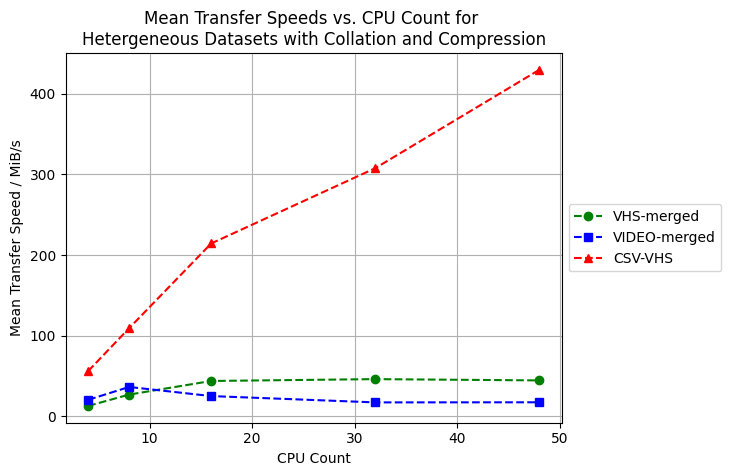

In [12]:
# Plot the mean transfer speeds against file size
plt.plot(compressed_df[compressed_df['Dataset'] == 'VHS-merged']['CPU Count'], compressed_df[compressed_df['Dataset'] == 'VHS-merged']['Transfer Speed / MiB/s'], marker='o', linestyle='--', color='g', label='VHS-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'VIDEO-merged']['CPU Count'], compressed_df[compressed_df['Dataset'] == 'VIDEO-merged']['Transfer Speed / MiB/s'], marker='s', linestyle='--', color='b', label='VIDEO-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'CSV-VHS']['CPU Count'], compressed_df[compressed_df['Dataset'] == 'CSV-VHS']['Transfer Speed / MiB/s'], marker='^', linestyle='--', color='r', label='CSV-VHS')
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('CPU Count')
plt.ylabel('Mean Transfer Speed / MiB/s')
plt.title('Mean Transfer Speeds vs. CPU Count for \nHetergeneous Datasets with Collation and Compression') 
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
compressed_df[compressed_df['Dataset'] == 'VHS-merged']['Total Time']

107   0 days 00:00:36.491689
110   0 days 00:00:17.390413
113   0 days 00:00:10.476815
116   0 days 00:00:09.955203
119   0 days 00:00:10.313800
Name: Total Time, dtype: timedelta64[ns]

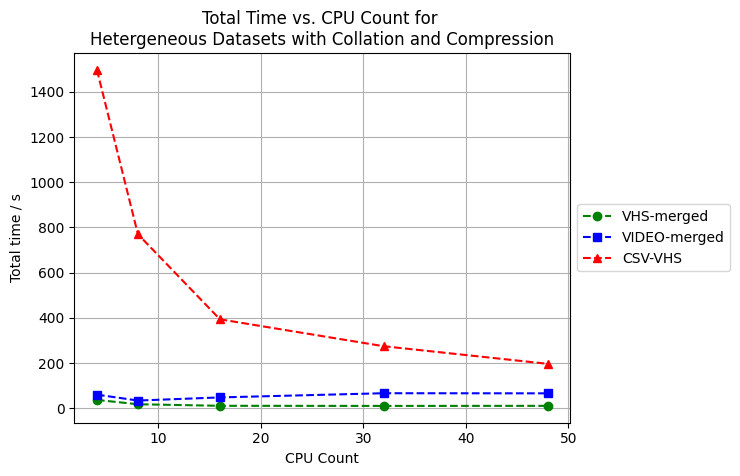

In [14]:
times = []
for dataset in ['VHS-merged', 'VIDEO-merged', 'CSV-VHS']:
    a = []
    for i in range(0, len(compressed_df[compressed_df['Dataset'] == 'VHS-merged']['Total Time'])):
        a.append(compressed_df[compressed_df['Dataset'] == dataset]['Total Time'].iloc[i].seconds + compressed_df[compressed_df['Dataset'] == dataset]['Total Time'].iloc[i].microseconds/1e6)
    times.append(a)
# Plot the mean transfer speeds against file size
plt.plot(compressed_df[compressed_df['Dataset'] == 'VHS-merged']['CPU Count'], times[0], marker='o', linestyle='--', color='g', label='VHS-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'VIDEO-merged']['CPU Count'], times[1], marker='s', linestyle='--', color='b', label='VIDEO-merged')
plt.plot(compressed_df[compressed_df['Dataset'] == 'CSV-VHS']['CPU Count'], times[2], marker='^', linestyle='--', color='r', label='CSV-VHS')
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
plt.xlabel('CPU Count')
plt.ylabel('Total time / s')
plt.title('Total Time vs. CPU Count for \nHetergeneous Datasets with Collation and Compression') 
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

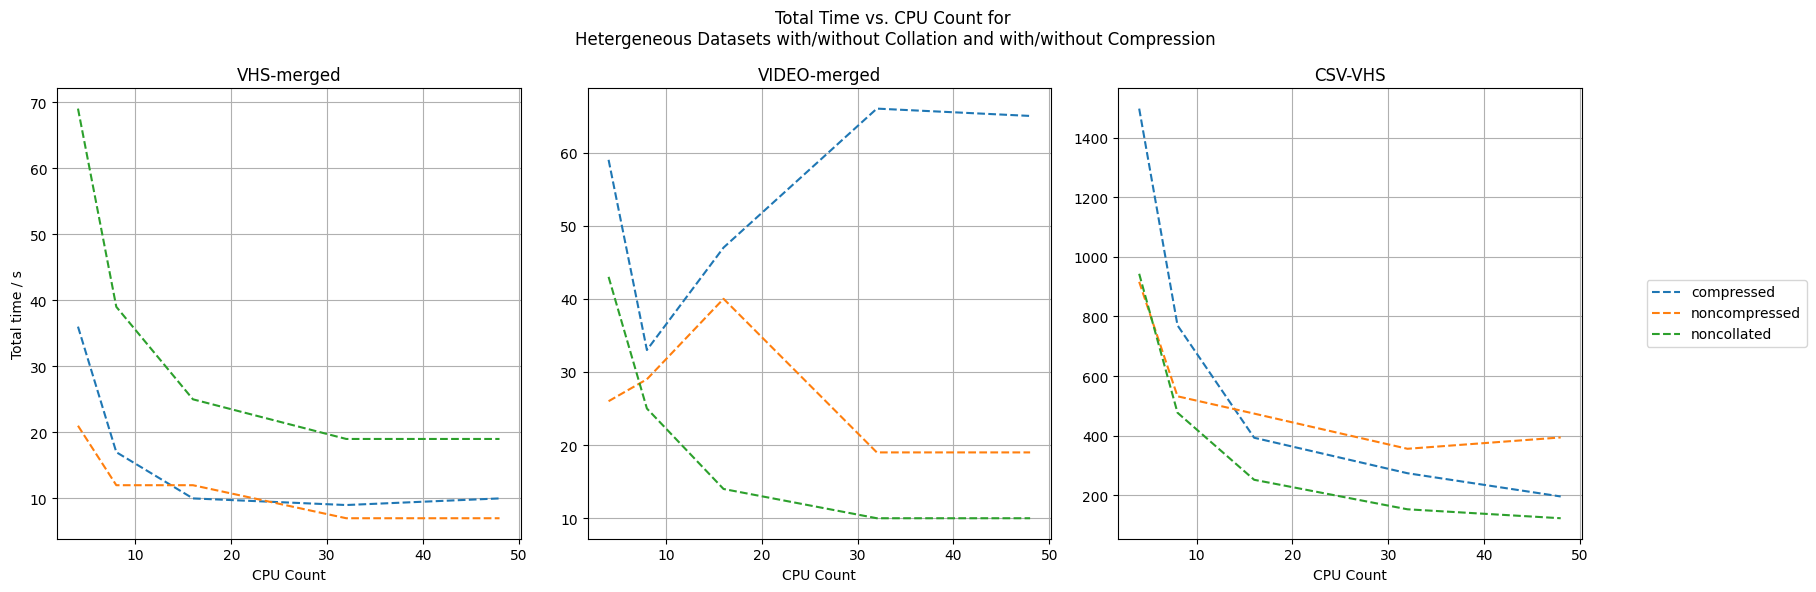

In [15]:

fig, ax = plt.subplots(1,3, figsize=(18,6))

for df in compressed_df, noncompressed_df, noncollated_df:
    df_name = [name for name, value in globals().items() if value is df and not name.startswith('_')][0]
    # print(df_name)
    for j, dataset in enumerate(['VHS-merged', 'VIDEO-merged', 'CSV-VHS']):
        # print(df[df['Dataset'] == dataset]['Total Time'])
        # times = []
        # for i in range(0, len(df[df['Dataset'] == dataset]['Total Time'])):
        #     times.append(df[df['Dataset'] == dataset]['Total Time'].iloc[i].seconds + df[df['Dataset'] == dataset]['Total Time'].iloc[i].microseconds/1e6)
        # times.append(a)
        # print(a)
        # print(len(df[df['Dataset'] == 'VHS-merged']['CPU Count']))
        # print(len(times))
        # print(len(df[df['Dataset'] == dataset]['CPU Count']))
        ax[j].plot(df[df['Dataset'] == dataset]['CPU Count'], df[df['Dataset'] == dataset]['Total Time']/1e9, linestyle='--', label=f"{df_name.split('_')[0]}")
        ax[j].title.set_text(f'{dataset}')
        ax[j].set_xlabel('CPU Count')
        ax[j].grid(True)
        
        # ax[j].set_ylabel('Total time / s')
        # ax[j].legend(loc='center', bbox_to_anchor=(1, 0.5))
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
# plt.xlabel('CPU Count')
ax[0].set_ylabel('Total time / s')
plt.legend(loc='center right', bbox_to_anchor=(1.5,0.5))
plt.suptitle('Total Time vs. CPU Count for \nHetergeneous Datasets with/without Collation and with/without Compression')
plt.tight_layout()
plt.show()

In [16]:
dummy_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
15,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,190.942981,0.52,4,0 days 00:00:02.052400,96.959657,0 days 00:01:44.219594,19900.00,200,False,False
16,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,180.511203,0.55,4,0 days 00:00:02.140503,93.201218,0 days 00:01:50.242465,19900.00,199,True,False
17,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,178.525934,0.56,4,0 days 00:00:02.187638,90.963623,0 days 00:01:50.908816,19800.10,199,True,True
18,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,359.615199,0.28,8,0 days 00:00:02.120400,93.850217,0 days 00:00:55.336927,19900.00,200,False,False
19,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,347.659296,0.29,8,0 days 00:00:02.158241,92.435223,0 days 00:00:57.239948,19900.00,199,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
85,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 50% Small Files,250.930399,0.59,32,0 days 00:00:03.094902,79.194151,0 days 00:00:59.777572,15000.01,102,True,False
86,collate_strategy-test_dummy-data_collation_50p...,Dummy Data 50% Small Files,350.633105,0.28,32,0 days 00:00:02.830000,69.302536,0 days 00:00:28.533729,10004.87,102,True,True
87,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 50% Small Files,640.763831,0.12,48,0 days 00:00:04.358850,34.412746,0 days 00:00:23.409561,15000.00,200,False,False
88,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 50% Small Files,168.354904,0.87,48,0 days 00:00:04.355588,56.272112,0 days 00:01:29.097553,15000.01,102,True,False


In [17]:
dummy_noncollated_df = dummy_df[dummy_df['Collated'] == False]
dummy_collated_df = dummy_df[dummy_df['Collated'] == True]
dummy_noncompressed_df = dummy_collated_df[dummy_collated_df['Compressed'] == False]
dummy_compressed_df = dummy_collated_df[dummy_collated_df['Compressed'] == True]
# del dummy_collated_df, noncollated_df, noncompressed_df, collated_df

In [18]:
dummy_df

,Title,Dataset,Transfer Speed / MiB/s,Seconds per File,CPU Count,Average Time per Upload / s,Average Speed per Upload / MiB/s,Total Time,Total MiB Uploaded,Total Files Uploaded,Collated,Compressed
15,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,190.942981,0.52,4,0 days 00:00:02.052400,96.959657,0 days 00:01:44.219594,19900.00,200,False,False
16,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,180.511203,0.55,4,0 days 00:00:02.140503,93.201218,0 days 00:01:50.242465,19900.00,199,True,False
17,collate_strategy-test_dummy-data_collation_1pe...,Dummy Data 1% Small Files,178.525934,0.56,4,0 days 00:00:02.187638,90.963623,0 days 00:01:50.908816,19800.10,199,True,True
18,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 1% Small Files,359.615199,0.28,8,0 days 00:00:02.120400,93.850217,0 days 00:00:55.336927,19900.00,200,False,False
19,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 1% Small Files,347.659296,0.29,8,0 days 00:00:02.158241,92.435223,0 days 00:00:57.239948,19900.00,199,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
85,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 50% Small Files,250.930399,0.59,32,0 days 00:00:03.094902,79.194151,0 days 00:00:59.777572,15000.01,102,True,False
86,collate_strategy-test_dummy-data_collation_50p...,Dummy Data 50% Small Files,350.633105,0.28,32,0 days 00:00:02.830000,69.302536,0 days 00:00:28.533729,10004.87,102,True,True
87,no-collate_strategy-test_dummy-data_no-collati...,Dummy Data 50% Small Files,640.763831,0.12,48,0 days 00:00:04.358850,34.412746,0 days 00:00:23.409561,15000.00,200,False,False
88,no-compression_strategy-test_dummy-data_no-com...,Dummy Data 50% Small Files,168.354904,0.87,48,0 days 00:00:04.355588,56.272112,0 days 00:01:29.097553,15000.01,102,True,False


In [79]:
print(dummy_df['Dataset'].unique())

['Dummy Data 1% Small Files' 'Dummy Data 10% Small Files'
 'Dummy Data 100% Small Files' 'Dummy Data 25% Small Files'
 'Dummy Data 50% Small Files']


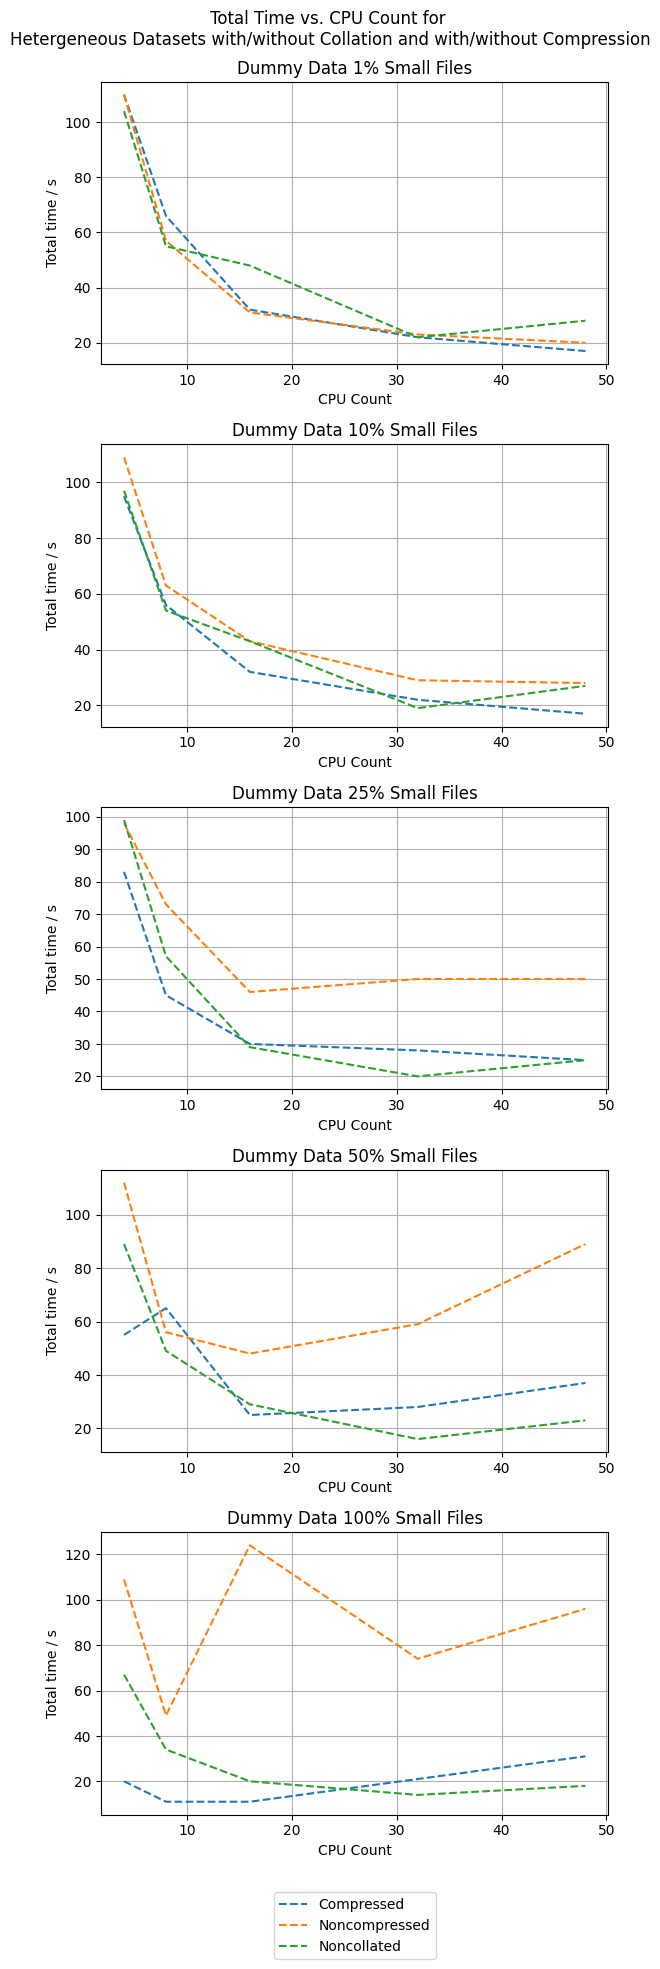

In [80]:

fig, ax = plt.subplots(5,1, figsize=(6,20))

for i, df in enumerate([dummy_compressed_df, dummy_noncompressed_df, dummy_noncollated_df]):
    if i == 0: 
        df_name = 'Compressed'
    elif i == 1:
        df_name = 'Noncompressed'
    else:
        df_name = 'Noncollated'
    # print(df_name)
    for j, dataset in enumerate(['Dummy Data 1% Small Files', 'Dummy Data 10% Small Files', 'Dummy Data 25% Small Files', 'Dummy Data 50% Small Files', 'Dummy Data 100% Small Files']):

        # for k in 0, 1:
        # print(dataset)
        # print(df[df['Dataset'] == dataset]['Total Time'].values/1e9)
        # print(df[df['Dataset'] == dataset]['CPU Count'])
        # print(len(df[df['Dataset'] == dataset]['CPU Count']))
        # print(len(df[df['Dataset'] == dataset]['Total Time']))
        # if j == 2 and k == 1:
        #     ax[j][k].plot()
        # else:
        ax[j].plot(df[df['Dataset'] == dataset]['CPU Count'], df[df['Dataset'] == dataset]['Total Time']/1e9, linestyle='--', label=f"{df_name}")
        ax[j].title.set_text(f'{dataset}')
        ax[j].set_xlabel('CPU Count')
        ax[j].set_ylabel('Total time / s')
        ax[j].grid(True)
        
        # ax[j].set_ylabel('Total time / s')
        # ax[j].legend(loc='center', bbox_to_anchor=(1, 0.5))
# plt.xticks(np.array([0,1,2,3,4,5,6,7,8])*64)
# plt.xlabel('CPU Count')

plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.25))
plt.suptitle('Total Time vs. CPU Count for \nHetergeneous Datasets with/without Collation and with/without Compression\n')
plt.tight_layout()
plt.show()